In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -a gdrive/MyDrive/Data\ Science\ Utils/. .

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import imageio
import glob
import skimage
import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import json

from skimage.transform import *
from skimage.color import *
from skimage.filters import threshold_mean

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Cropping2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rtatman/stamp-verification-staver-dataset

100% 1.85G/1.86G [00:11<00:00, 185MB/s]
100% 1.86G/1.86G [00:11<00:00, 170MB/s]


In [ ]:
! unzip stamp-verification-staver-dataset.zip

In [ ]:
# %%
path_to_data = ""
SCANS_DIR = path_to_data + "./scans/scans/"
TRUTH_DIR = path_to_data + "./ground-truth-pixel/ground-truth-pixel/"

# IMG_SIZE = (2302, 1632, 3)

# IMG_SIZE = (2304, 1632, 3)
IMG_SIZE = (1152, 816, 3)

scan_files = glob.glob(SCANS_DIR + '*.png')
scan_files = sorted(scan_files)
scan_files_train = scan_files[:400]
scan_files_test = scan_files[400:]
truth_files = glob.glob(TRUTH_DIR + '*.png')
truth_files = sorted(truth_files)

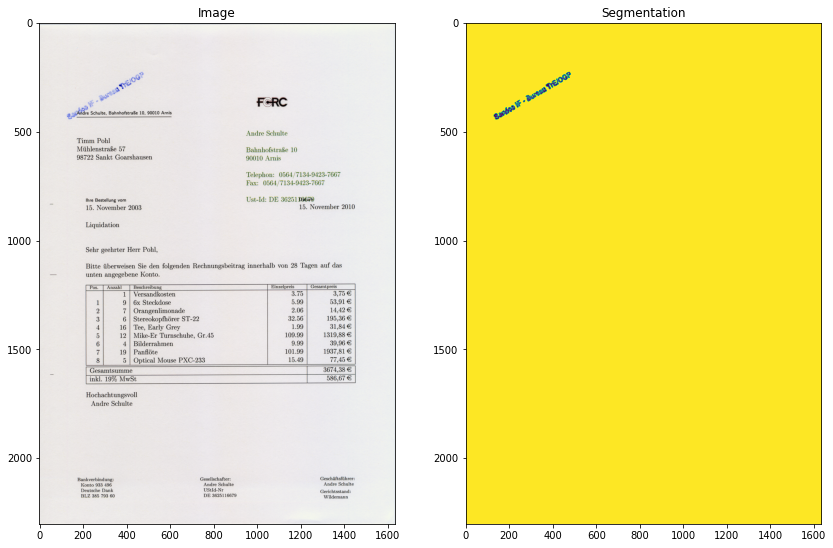

In [ ]:
N = 2
img = imageio.imread(scan_files[N])
mask = imageio.imread(truth_files[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
plt.show()

In [ ]:
scan_files_train_selected = scan_files_train[0:400]
truth_files_selected = truth_files[0:400]
pd.DataFrame({'scan': scan_files_train_selected, 'truth': truth_files_selected}).tail()

scan  \
395  ./scans/scans/stampDS-00396.png   
396  ./scans/scans/stampDS-00397.png   
397  ./scans/scans/stampDS-00398.png   
398  ./scans/scans/stampDS-00399.png   
399  ./scans/scans/stampDS-00400.png   

                                                 truth  
395  ./ground-truth-pixel/ground-truth-pixel/stampD...  
396  ./ground-truth-pixel/ground-truth-pixel/stampD...  
397  ./ground-truth-pixel/ground-truth-pixel/stampD...  
398  ./ground-truth-pixel/ground-truth-pixel/stampD...  
399  ./ground-truth-pixel/ground-truth-pixel/stampD...

In [ ]:
def calc_sample_weight(label, image):
    image = rgb2gray(image)
    around_texts = cv2.dilate((image < 0.5).astype(np.uint8) | label, np.ones((2, 2)))
    combined = around_texts + label
    class_counts = np.unique(combined, return_counts=True)[1]
    class_weight = np.sum(class_counts) / class_counts * np.array([1, 1, 2])[:len(class_counts)]
    # class_weight = class_weight / np.max(class_weight)
    weights = np.vectorize(lambda x: class_weight[x])(combined).flatten()
    return weights, class_counts, class_weight

In [ ]:
def image_generator(files, randomized=True,
                    labels=None,
                    include_weights=False,
                    batch_size=1,
                    augment=False,
                    gamma_range=(1, 1),
                    jitter_range=0):
    img_batch = []
    label_batch = []
    weight_batch = []
    while True:
        indices = range(len(files))
        if randomized:
            indices = np.random.randint(len(files), size=len(files))
        for i in indices:
            if len(img_batch) >= batch_size:
                img_batch = []
                label_batch = []
                weight_batch = []
            img = imageio.imread(files[i])
            # print(files[i])

            need_resizement = (img.shape[0] > IMG_SIZE[0]) or (img.shape[1] > IMG_SIZE[1])
            
            if need_resizement:
                scale = min(IMG_SIZE[1] / img.shape[1], IMG_SIZE[0] / img.shape[0])
                height = int(img.shape[0] * scale)
                width = int(img.shape[1] * scale)
                dim = (width, height)
                img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

            img = img / 255
            img = cv2.copyMakeBorder(img,
                                     (IMG_SIZE[0] - img.shape[0]) // 2,
                                     (IMG_SIZE[0] - img.shape[0]) - (IMG_SIZE[0] - img.shape[0]) // 2,
                                     (IMG_SIZE[1] - img.shape[1]) // 2,
                                     (IMG_SIZE[1] - img.shape[1]) - (IMG_SIZE[1] - img.shape[1]) // 2,
                                     cv2.BORDER_REFLECT)
            label = None
            if labels is not None:
                label = imageio.imread(labels[i])
                
                 if need_resizement:
                    label = cv2.resize(label, dim, interpolation=cv2.INTER_NEAREST)

                label = (255 - label) / 255
                label = label[:, :, 0].astype(np.uint8)
                label = cv2.copyMakeBorder(label,
                                           (IMG_SIZE[0] - label.shape[0]) // 2,
                                           (IMG_SIZE[0] - label.shape[0]) - (
                                                   IMG_SIZE[0] - label.shape[0]) // 2,
                                           (IMG_SIZE[1] - label.shape[1]) // 2,
                                           (IMG_SIZE[1] - label.shape[1]) - (
                                                   IMG_SIZE[1] - label.shape[1]) // 2,
                                           cv2.BORDER_REFLECT)
            if augment:
                gamma = np.random.uniform(gamma_range[0], gamma_range[1])
                img = img ** np.random.uniform(gamma_range[0], gamma_range[1])

                jitter = np.random.uniform(0, jitter_range, (4, 2)).astype(np.float32)
                pts1 = np.array(((0, 0), (IMG_SIZE[1], 0), (0, IMG_SIZE[0]),
                                 (IMG_SIZE[1], IMG_SIZE[0]))).astype(np.float32)
                pts2 = pts1 + jitter
                M = cv2.getPerspectiveTransform(pts1, pts2)
                img = cv2.warpPerspective(img, M, (IMG_SIZE[1], IMG_SIZE[0]), borderValue=(1, 1, 1))
                if labels is not None:
                    label = cv2.warpPerspective(label, M, (IMG_SIZE[1], IMG_SIZE[0]),
                                                flags=cv2.INTER_NEAREST, borderValue=0)

            img_batch.append(img)
            if labels is not None:
                if include_weights:
                    weight_batch.append(calc_sample_weight(label, img)[0])
                label_batch.append(label.reshape((IMG_SIZE[1] * IMG_SIZE[0], 1)))
            if len(img_batch) >= batch_size:
                if labels is not None:
                    if include_weights:
                        yield np.array(img_batch), np.array(label_batch), np.array(weight_batch)
                    else:
                        yield np.array(img_batch), np.array(label_batch)
                else:
                    yield np.array(img_batch)


In [ ]:
sanity_check_iterator = image_generator(scan_files_train_selected,
                                              labels=truth_files_selected,
                                              include_weights=True,
                                              batch_size=1,
                                              augment=True,
                                              gamma_range=(0.8, 0.8),
                                              jitter_range=50)

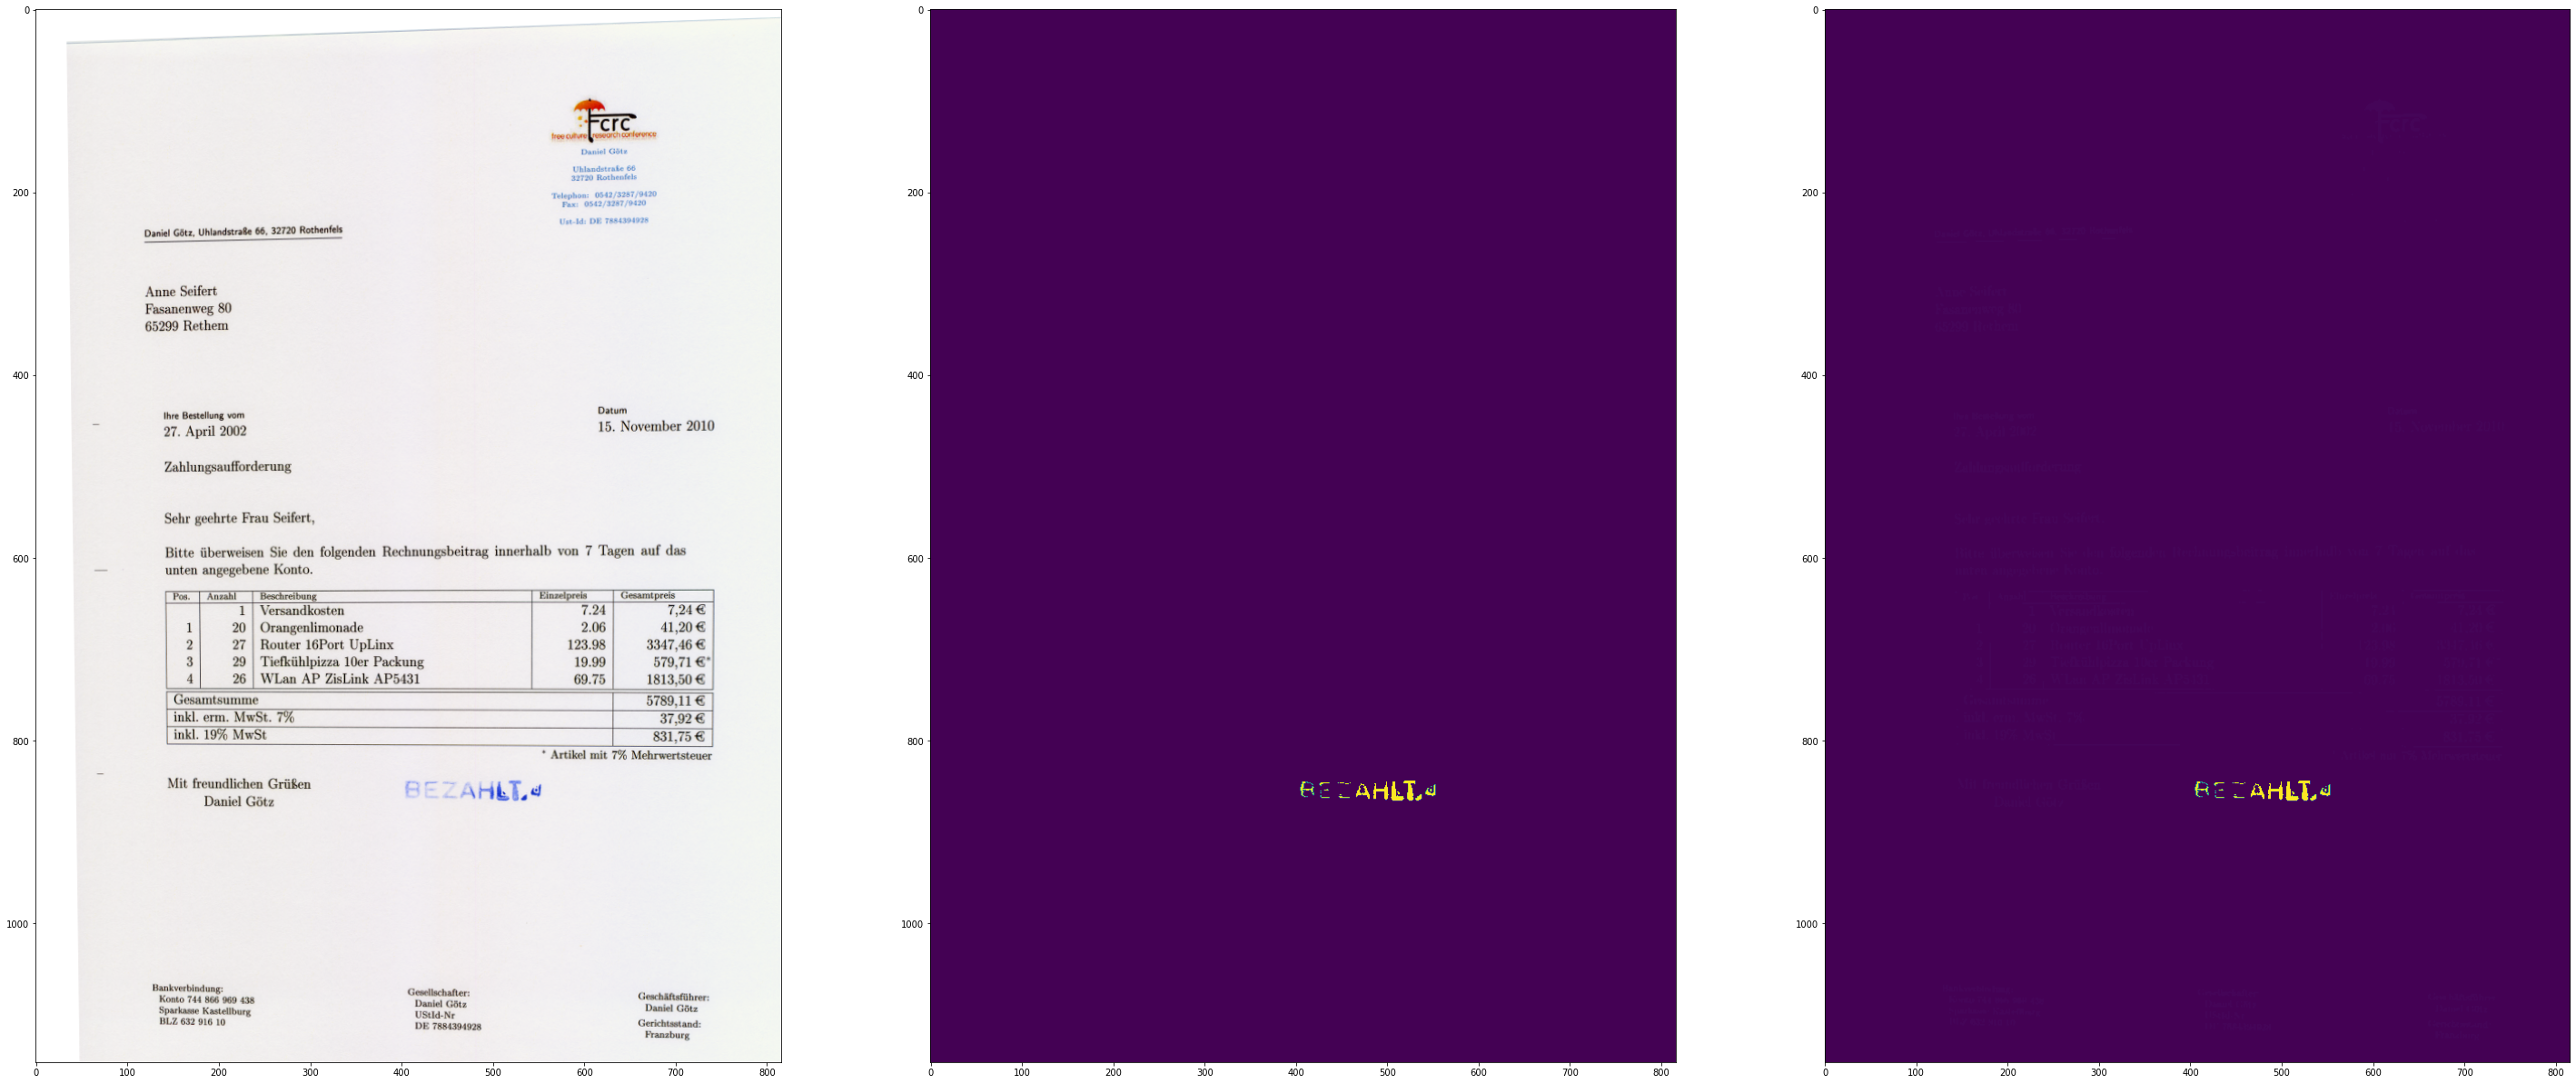

In [ ]:
scans, labels, weights = next(sanity_check_iterator)

plt.figure(figsize=(50, 50))
plt.subplot(1, 3, 1)
plt.imshow(scans[0]);
plt.subplot(1, 3, 2)
plt.imshow(labels[0].reshape((IMG_SIZE[0], IMG_SIZE[1])));
plt.subplot(1, 3, 3)
plt.imshow(weights[0].reshape((IMG_SIZE[0], IMG_SIZE[1])));
plt.show()

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0., max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
        ### END CODE HERE

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
        ### END CODE HERE

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    ### START CODE HERE
    up = Conv2DTranspose(
        n_filters,  # number of filters
        3,  # Kernel size
        strides=(2, 2),
        padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)

    conv = Conv2D(n_filters,  # Number of filters
                  3,  # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE

    return conv

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=2):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block.
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)  # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)

    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
    # At each step, use half the number of filters of the previous block
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    x = Reshape((IMG_SIZE[0] * IMG_SIZE[1], 1,))(conv10)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

In [ ]:
img_height = IMG_SIZE[0]
img_width = IMG_SIZE[1]
num_channels = 3
n_filters = 32
input_size = (img_height, img_width, num_channels)
input_size

(1152, 816, 3)

In [ ]:
unet = unet_model(input_size, n_filters=n_filters, n_classes=1)

In [ ]:
unet.summary()

In [ ]:
unet.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [ ]:
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
folder_to_save = "gdrive/MyDrive/saved_models/unet/" + timestamp + "/"
if not os.path.isdir(folder_to_save):
  os.mkdir(folder_to_save)

In [ ]:
with open(folder_to_save + "model_stats.txt", "w") as stream:
  unet.summary(print_fn=lambda x: stream.write(x + '\n'))

In [ ]:
BATCH_SIZE = 2
EPOCHS = 40

In [ ]:
train_set = image_generator(scan_files_train_selected,
                            labels=truth_files_selected,
                            include_weights=True,
                            batch_size=BATCH_SIZE,
                            augment=True,
                            gamma_range=(0.8, 1.25),
                            jitter_range=50)

validation_set = image_generator(scan_files_train_selected,
                                 labels=truth_files_selected,
                                 include_weights=True,
                                 batch_size=BATCH_SIZE,
                                 augment=True,
                                 gamma_range=(0.8, 1.25),
                                 jitter_range=50)


In [ ]:
config = {"EPOCHS" : EPOCHS, 
          "BATCH_SIZE" : BATCH_SIZE,
          "n_filters" : n_filters,
          "loss_function" : "BinaryCrossentropy",
          "optimizer" : "adam",
          "metrics" : ["accuracy"]}

with open(folder_to_save + "model_config.txt", "w") as stream:
  stream.write(json.dumps(config))

In [ ]:
from re import VERBOSE
model_history = unet.fit(train_set,
                         validation_data=validation_set,
                         validation_steps=3,
                         steps_per_epoch=len(scan_files_train_selected) // BATCH_SIZE,
                         max_queue_size=1,
                         epochs=EPOCHS,
                         callbacks=[ModelCheckpoint(folder_to_save + 'stamp.weights.{epoch:04d}.hdf5', save_weights_only=True)], 
                         verbose = True)

Epoch 1/40
200/200 [==============================] - 297s 1s/step - loss: 1.2049 - accuracy: 0.9900 - val_loss: 0.7609 - val_accuracy: 0.9984
Epoch 2/40
200/200 [==============================] - 286s 1s/step - loss: 0.7902 - accuracy: 0.9945 - val_loss: 0.5073 - val_accuracy: 0.9971
Epoch 3/40
200/200 [==============================] - 280s 1s/step - loss: 0.8709 - accuracy: 0.9889 - val_loss: 0.7655 - val_accuracy: 0.9894
Epoch 4/40
200/200 [==============================] - 282s 1s/step - loss: 0.6960 - accuracy: 0.9938 - val_loss: 0.1944 - val_accuracy: 0.9980
Epoch 5/40
200/200 [==============================] - 279s 1s/step - loss: 0.7098 - accuracy: 0.9930 - val_loss: 0.5412 - val_accuracy: 0.9952
Epoch 6/40
200/200 [==============================] - 283s 1s/step - loss: 0.6153 - accuracy: 0.9938 - val_loss: 0.5282 - val_accuracy: 0.9941
Epoch 7/40
200/200 [==============================] - 278s 1s/step - loss: 0.8551 - accuracy: 0.9742 - val_loss: 0.7116 - val_accuracy: 0.9962

In [ ]:
import csv

with open(folder_to_save + 'mycsvfile.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, model_history.history.keys())
    w.writeheader()
    w.writerow(model_history.history)

NameError: ignored

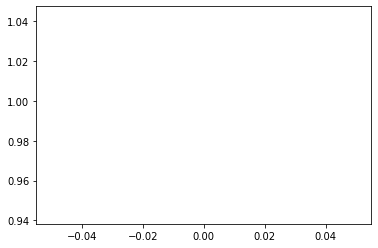

In [ ]:
plt.plot(model_history.history["accuracy"])
plt.show()

In [ ]:
steps=len(scan_files_test[0:10])
checkpoints = sorted(glob.glob(folder_to_save + '*.hdf5'))
rows = len(checkpoints)+1
checkpoints

['gdrive/MyDrive/saved_models/unet/2022_04_18_18_48_14/stamp.weights.0001.hdf5']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


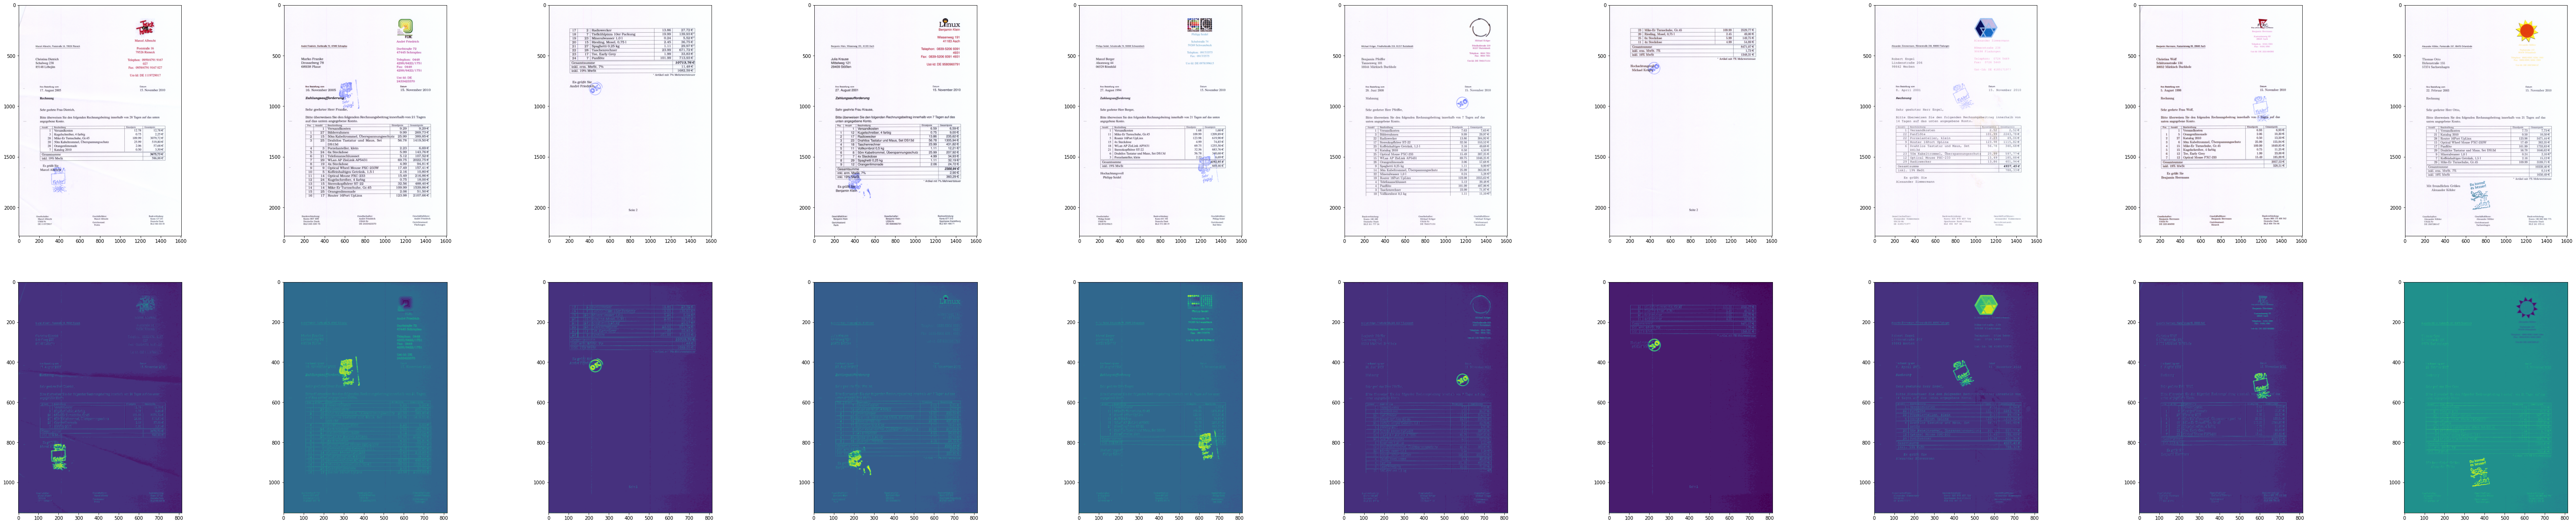

In [ ]:
plt.figure(figsize=(steps*10, rows*10))
for i in range(steps):
    plt.subplot(rows,steps,i+1)
    plt.imshow(imageio.imread(scan_files_test[i]))
for i, c in enumerate(checkpoints):
    unet.load_weights(c)
    predicted = unet.predict_generator(image_generator(scan_files_test, randomized=False, labels=None, include_weights=False, batch_size=1, augment=False),
                                       steps=steps)
    predicted = np.round(predicted).reshape((steps,IMG_SIZE[0],IMG_SIZE[1]))
    for s in range(steps):
        plt.subplot(rows,steps,i*steps+s+steps+1)
        plt.imshow(predicted[s])